In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import awkward as ak 
import numpy as np
import matplotlib.pyplot as plt
import fastjet
from coffea.nanoevents import NanoEventsFactory, EDM4HEPSchema
import dask_awkward as dak
import hist.dask as hda
from ak_tools import ak_equals

In [3]:
# this is the old edm4hep file... needs to be changed to the new edm4hep structure to be able to run with coffea
events = NanoEventsFactory.from_root( 
    {"../../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004" 
    ".Pe2e2h.eR.pL.n000.d_dstm_15090_*.slcio.edm4hep.root"
    :"events"},
    schemaclass=EDM4HEPSchema,
    permit_dask=True,
    metadata = {'b_field':5},
).events()

/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:63: UserWarning: Skipping PARAMETERS as it is it cannot be interpreted by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.second as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skippin

The two steps below could be combined, but it's a good example of event level and inner event slicing

In [4]:
# finds all events with a muon pair with invariant mass between 80 and 100 GeV
mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)

# finds indices of all pairs of muons between 80 and 100 GeV
pfopair = dak.argcombinations(events.PandoraPFOs, 2, fields=["p1", "p2"])
all_muons_mask = (abs(events.PandoraPFOs[pfopair.p1].pdgId) == 13) & (abs(events.PandoraPFOs[pfopair.p2].pdgId) == 13)
invmass = (events.PandoraPFOs[pfopair.p1][all_muons_mask] + events.PandoraPFOs[pfopair.p2][all_muons_mask]).mass

inds = dak.singletons(dak.argmin(abs(invmass - 91.2), axis=1))

mu1ind = pfopair.p1[all_muons_mask][inds]
mu2ind = pfopair.p2[all_muons_mask][inds]

### Before fastjet Bug is Fixed
The next two cells are to get around the fastjet masking problem. If it is fixed, this should produce the same results as the cells below the plot.

In [5]:
m1 = mu1ind[muonsevent].compute()
m2 = mu2ind[muonsevent].compute()
p = events.PandoraPFOs[muonsevent].compute()

In [6]:
%%time
x = []
y = []
z = []
E = []

local_inds = ak.local_index(p)
total_mask = ((ak_equals(local_inds, m1)) | (ak_equals(local_inds, m2))) != True

for n in range(len(p)):
    x.append(np.array(p.x[n][total_mask[n]]))
    y.append(np.array(p.y[n][total_mask[n]]))
    z.append(np.array(p.z[n][total_mask[n]]))
    E.append(np.array(p.E[n][total_mask[n]]))

x = ak.Array(x)
y = ak.Array(y)
z = ak.Array(z)
E = ak.Array(E)

CPU times: user 2min 3s, sys: 2.49 s, total: 2min 6s
Wall time: 2min 40s


In [7]:
select_pfos = ak.zip(
    {
        'px': x,
        'py': y,
        'pz': z,
        'E': E,
    },
    with_name="LorentzVector",
)

In [8]:
jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1)

# if this every throws the error 'Caught an unknown exception!', it means there are fewer particles in an event 
# than the number of jets you want to make
select_clst = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets(n_jets=2)

# sets up jets with same functionality as pfos using coffea 
jets = ak.zip(
    {
        'x': select_clst["px"],
        'y': select_clst["py"],
        'z': select_clst["pz"],
        't': select_clst["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Text(0.5, 0, 'Invariant Mass of Jets [GeV]')

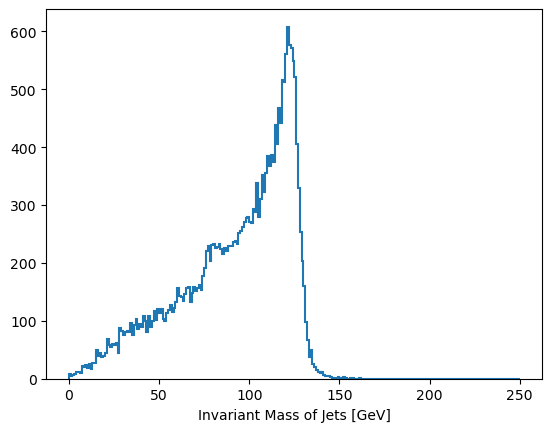

In [10]:
jetpair = ak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs

nbins = 250
mini = 0 
maxi = 250

plt.close(1);plt.figure(1)
plt.hist(ak.flatten((jetpair.jet1 + jetpair.jet2).mass),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
         linewidth=1.5,)

plt.xlabel('Invariant Mass of Jets [GeV]')

### After fastjet Bug is Fixed
The below should be the same as the above after the fastjet masking bug is fixed. Right now this does not work!

In [5]:
m1 = mu1ind[muonsevent]
m2 = mu2ind[muonsevent]

local_inds = dak.local_index(events.PandoraPFOs[muonsevent])

# need to flatten the array that you're comparing to for '=='
total_mask = ((ak.flatten(m1) == local_inds) | (ak.flatten(m2) == local_inds)) != True

select_pfos = events.PandoraPFOs[muonsevent][total_mask] 

In [6]:
jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1)
select_clst = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets(n_jets=2)

jets = ak.zip(
    {
        'x': select_clst["px"],
        'y': select_clst["py"],
        'z': select_clst["pz"],
        't': select_clst["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


{'from-uproot-4b1ef0c0b146ddae6a0bd709a65cecb0': ['PandoraPFOs.t',
  'PandoraPFOs.z',
  'PandoraPFOs.charge',
  'PandoraPFOs.x',
  'PandoraPFOs.y',
  'PandoraPFOs.pdgId']}

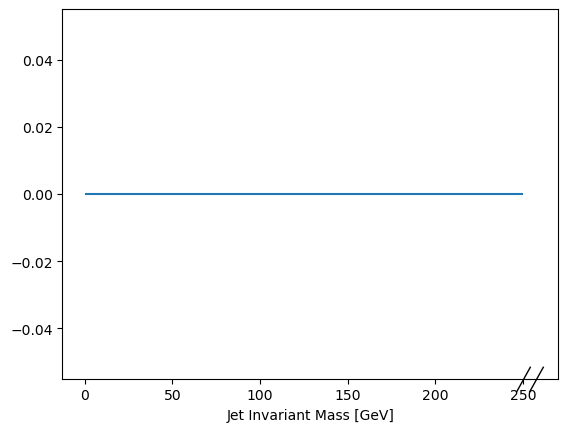

In [7]:
jetpair = ak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs

nbins = 250
mini = 0 
maxi = 250

energy_hist_clusters = (
    hda.Hist.new.Reg(nbins, mini, maxi, name="pt", label="Jet Invariant Mass [GeV]")
    .Double()
    .fill(ak.flatten((jetpair.jet1 + jetpair.jet2).mass))
)

energy_hist_clusters.compute().plot1d(label='PandoraClusters')
dak.necessary_columns(energy_hist_clusters)

Right now the bug in fastjet makes this a flat line. Hopefully once it's fixed this will work!!